In [ ]:
import pickle

ref_data = [{} for i in range(8)]
total_nums = [0,0,100,0,0,96525,45540,990]

for i in range(5, 8):
	file_path = f'../assets/db/db{i}.pkl'
	with open(file_path, 'rb') as fp:
		ref_data[i] = pickle.load(fp)

In [3]:
import ast

total_data = []
for i in range(2):
	file_path = f'../assets/slumbot/backup/mixed/record-500-{i+5}.txt'
	with open(file_path, "r") as file:
		for idx, line in enumerate(file):
			hand_data = {} 
			cols = line.split(",")
			hand_data['id'] = ast.literal_eval(cols[0][5:])
			hand_data['is_first'] = ast.literal_eval(cols[1][12:])
			hand_data['hand_win'] = ast.literal_eval(cols[2][12:])
			hand_data['total_win'] = ast.literal_eval(cols[3][13:])
			hand_data['history_action'] = cols[4][18:]
			hand_data['hole_cards'] = ast.literal_eval((','.join(cols[5:7]))[14:])
			hand_data['bot_hole_cards'] = ast.literal_eval((','.join(cols[7:9]))[18:])
			hand_data['board_cards'] = ast.literal_eval((','.join(cols[9:]))[15:])
			total_data.append(hand_data)
		file.close()
len(total_data)

1000

In [66]:
def transform(cards, idx):
    num_dict = {
        "s": 0,
        "h": 0,
        "c": 0,
        "d": 0,
    }
    
    for card in cards:
        num_dict[card[-1]] += 1
    
    max_suit = max(num_dict, key=num_dict.get)
    max_suit_count = num_dict[max_suit]

    MIN_NUM = {5: 3, 6: 4, 7: 5}
    if max_suit_count < MIN_NUM[idx]:
        return ''.join([f"{card[:-1]}" for card in cards])
    else:
        result = []
        for card in cards:
            suit = card[-1]
            if suit == max_suit:
                result.append(f"{card[:-1]}s") 
            else:
                result.append(f"{card[:-1]}o") 
        return ''.join(result)


from itertools import permutations

def find(code, idx):
    if len(code) == idx:
        all_permutations = [''.join(p) for p in permutations(code)]
    
    elif len(code) == idx*2:
        grouped = [code[i:i+2] for i in range(0, len(code), 2)]
        all_permutations = [''.join(p) for p in permutations(grouped)]
    
    else:
        return None

    for perm in all_permutations:
        if perm in ref_data[idx]:
            return [perm, ref_data[idx][perm]]

    print(f"{code} not found")
    
    return None
    
IDX = 7
side = 'slumbot' # or slumbot
cnts = [0 for i in range(8)]
my_data = [[] for i in range(8)]
for hand_data in total_data:
    cards = []
    hand_win = 0
    if side == 'model':
        cards = hand_data['hole_cards'] + hand_data['board_cards']
        hand_win = hand_data['hand_win']
    elif side == 'slumbot':
        cards = hand_data['bot_hole_cards'] + hand_data['board_cards']
        hand_win = -hand_data['hand_win']
    # stats
    idx = len(cards)
    cnts[idx] += 1
    if idx == IDX:
        code = transform(cards, idx)
        res = find(code, idx)
        if res == None: continue
        hit_code = res[0]
        draw = total_nums[IDX] - res[1][0] -res[1][1]
        # print(res[1][0], res[1][1], draw, total_nums[IDX])
        win_rate = (res[1][0] + draw / 2) / total_nums[IDX]
        
        my_data[idx].append({
			'cards': cards,
			'hand_win': hand_win,
			'code': code,
			'hit_code': hit_code,
			'win_rate': win_rate,
		})
len(my_data[IDX])

485

In [67]:
import pandas as pd

df = pd.DataFrame(my_data[IDX])
df

,cards,hand_win,code,hit_code,win_rate
0,"[8d, 5d, 8s, 7d, 2s, Ts, 2d]",-1200,85872T2,882257T,0.722727
1,"[Jc, 5h, Th, 6h, 5c, As, Kh]",-400,J5T65AK,JA556TK,0.501515
2,"[Js, 4h, Qd, Jd, 2s, As, Td]",-400,J4QJ2AT,JQ24TJA,0.765657
3,"[8s, 6d, Kc, 9d, 4s, Qh, 3c]",-200,86K94Q3,8K3469Q,0.230808
4,"[Kc, Tc, Qd, Ts, 2c, 5h, 8h]",600,KTQT258,TK258TQ,0.728283
...,...,...,...,...,...
480,"[4d, 3s, 7s, 4s, 2s, Jc, 7c]",400,43742J7,472347J,0.880808
481,"[8d, 3h, 7c, 4c, 2c, Qc, 7d]",-600,83742Q7,8Q23477,0.234848
482,"[7h, 2s, Kh, Ts, Td, Qd, 7d]",-100,72KTTQ7,7K27TTQ,0.745455
483,"[5h, 4c, Td, 4d, 2h, 7d, 9d]",400,54T4279,5T24479,0.101515


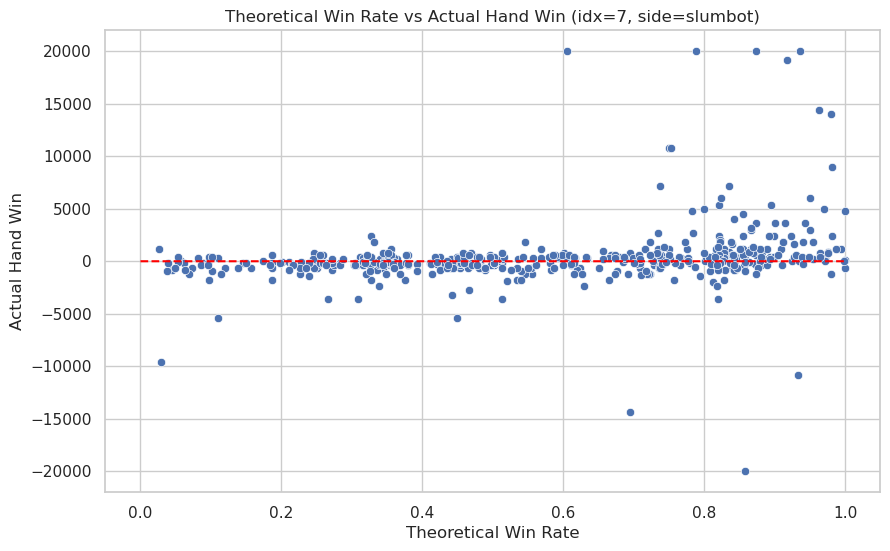

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='win_rate', y='hand_win', data=df)

scatter_plot.set_title(f'Theoretical Win Rate vs Actual Hand Win (idx={IDX}, side={side})')
scatter_plot.set_xlabel('Theoretical Win Rate')
scatter_plot.set_ylabel('Actual Hand Win')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.savefig(f'../assets/slumbot/stats/{side}-{IDX}')
plt.show()